In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

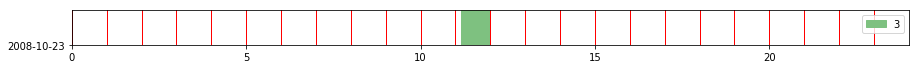

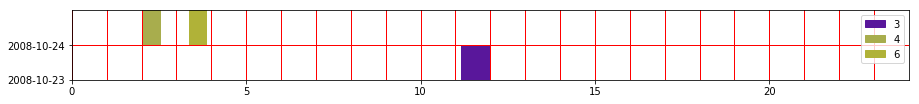

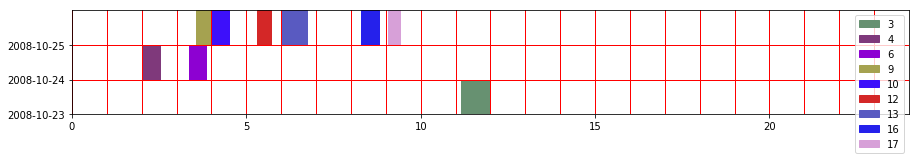

/home/shashank/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shashank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


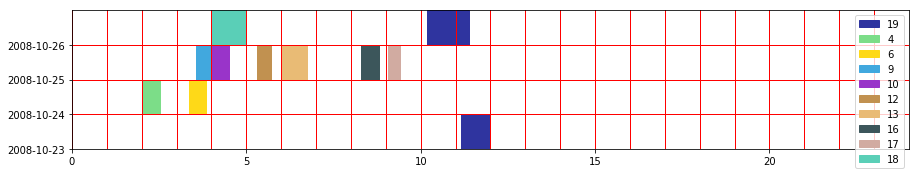

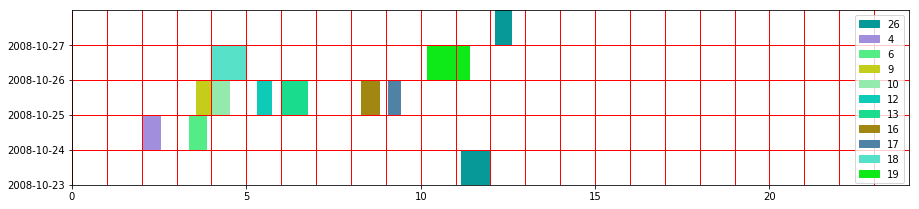

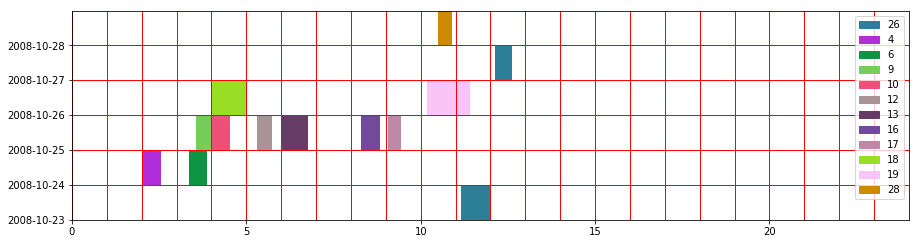

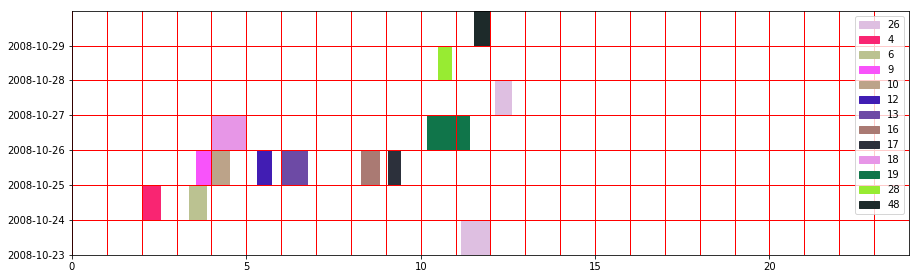

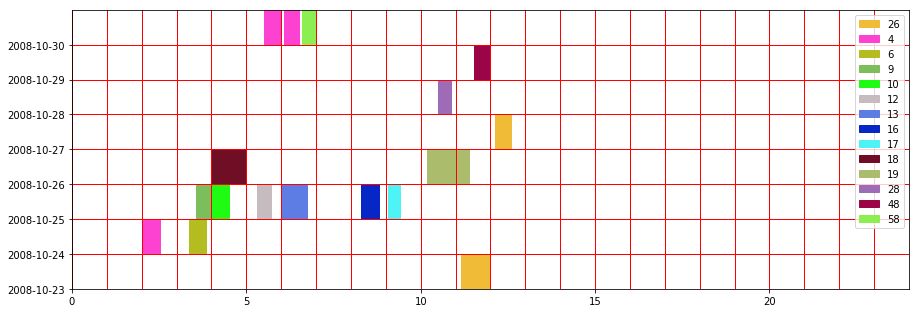

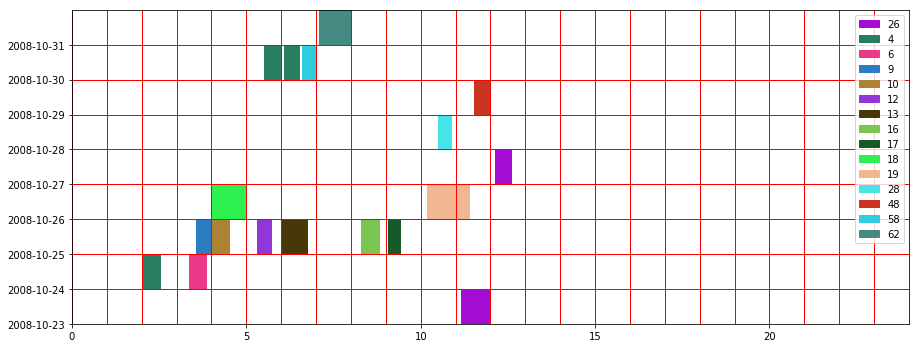

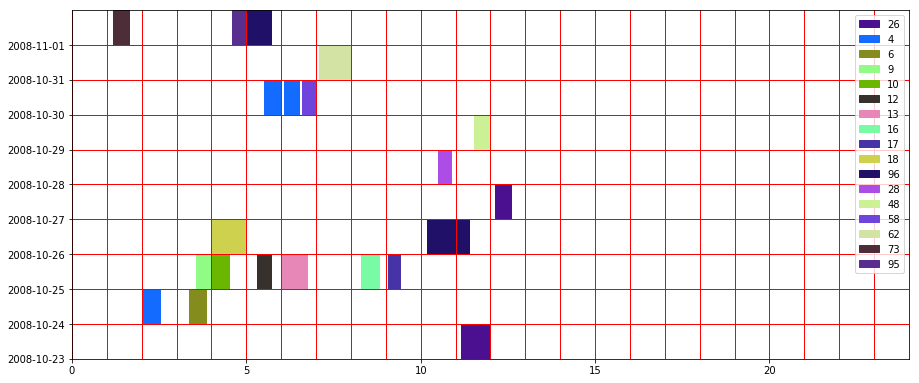

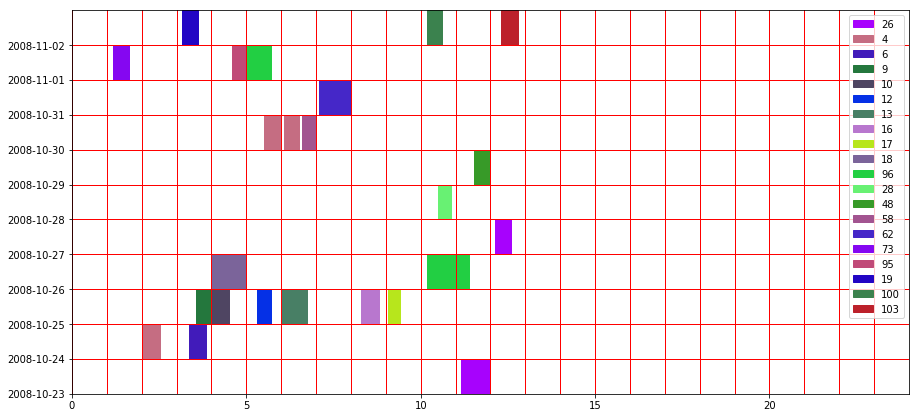

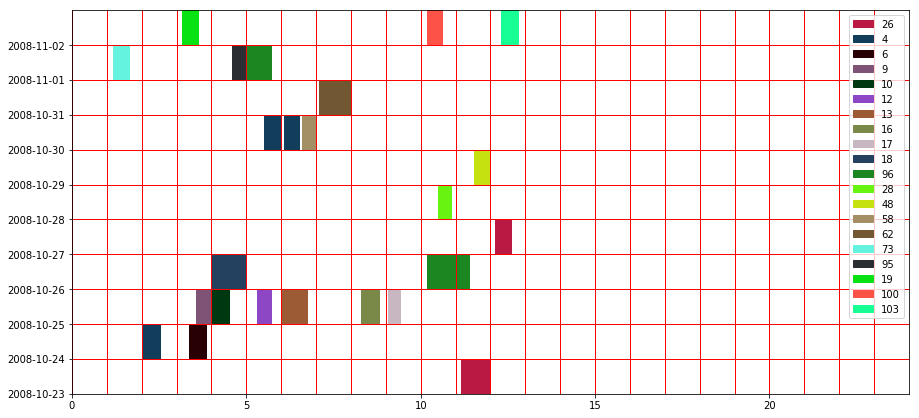

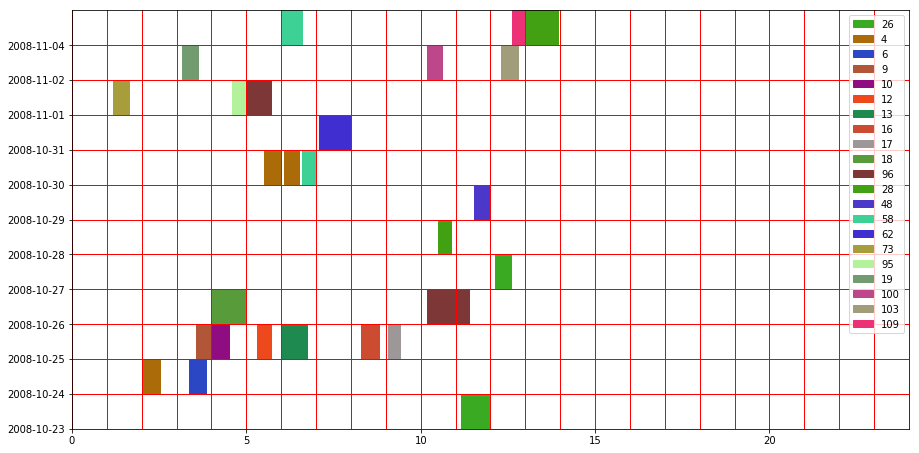

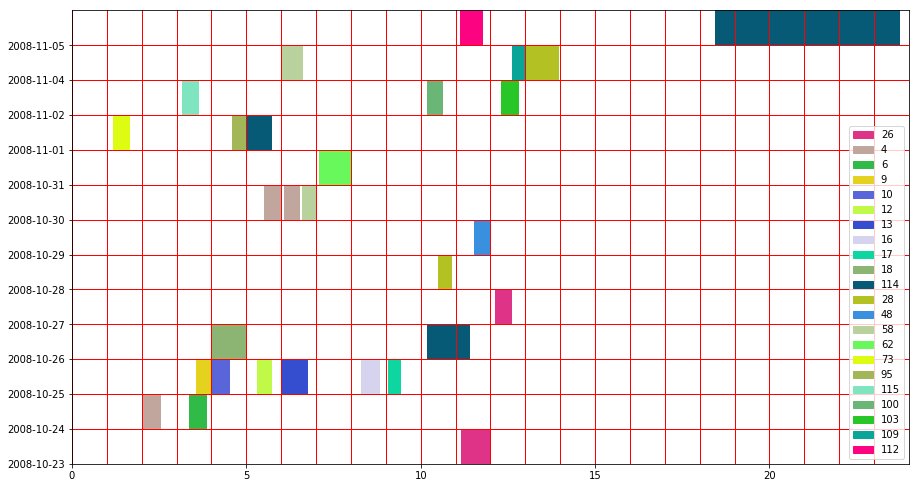

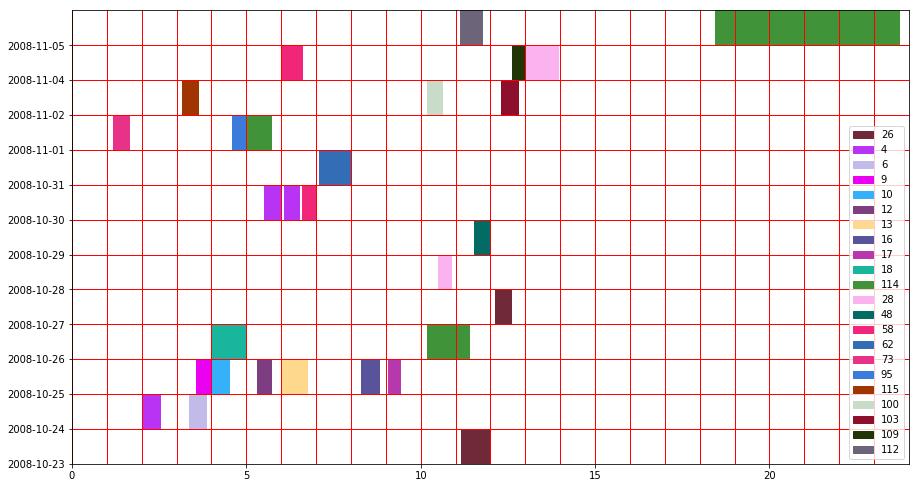

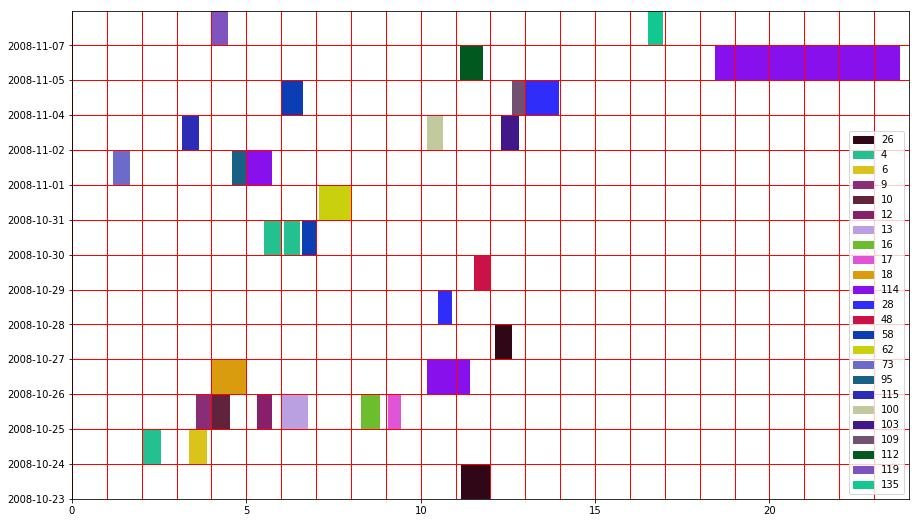

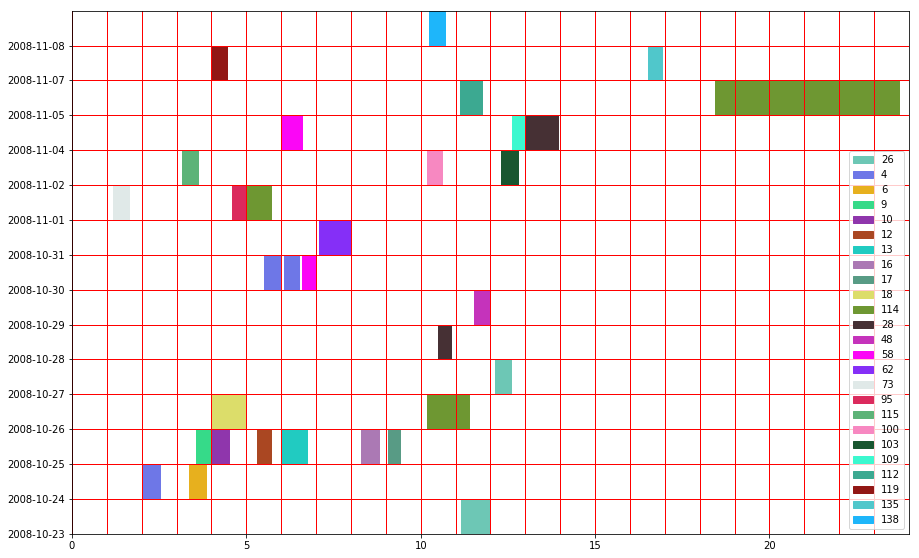

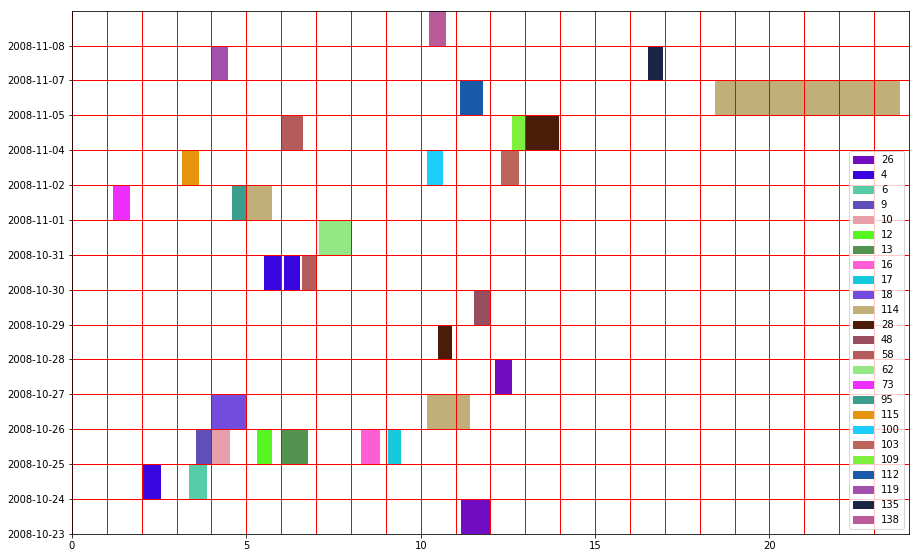

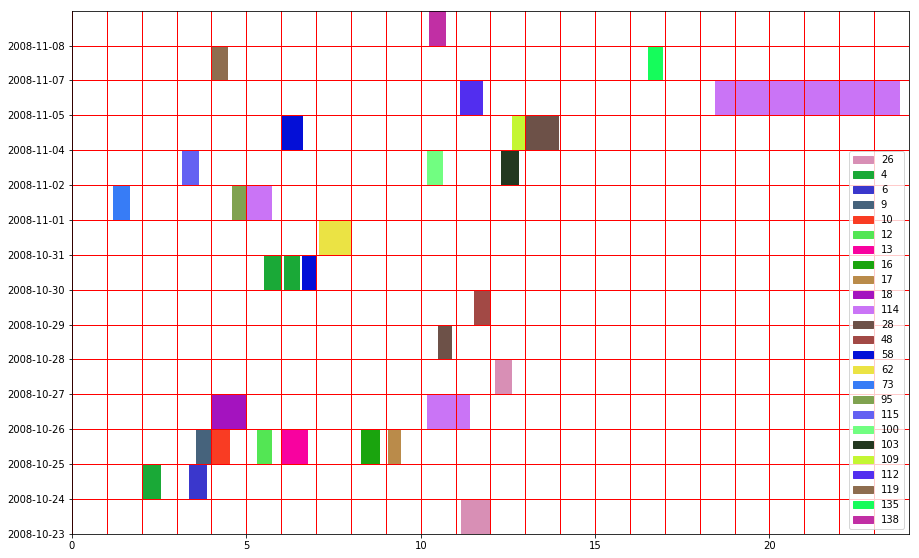

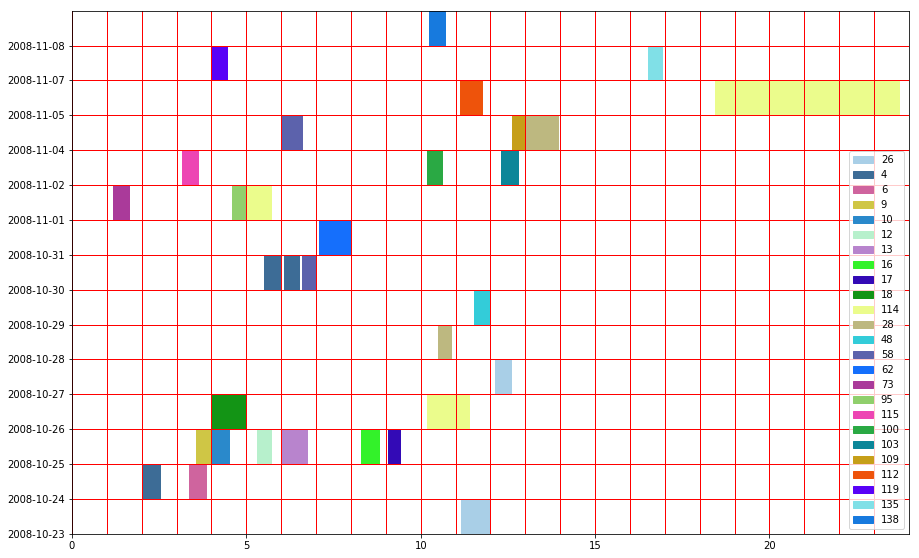

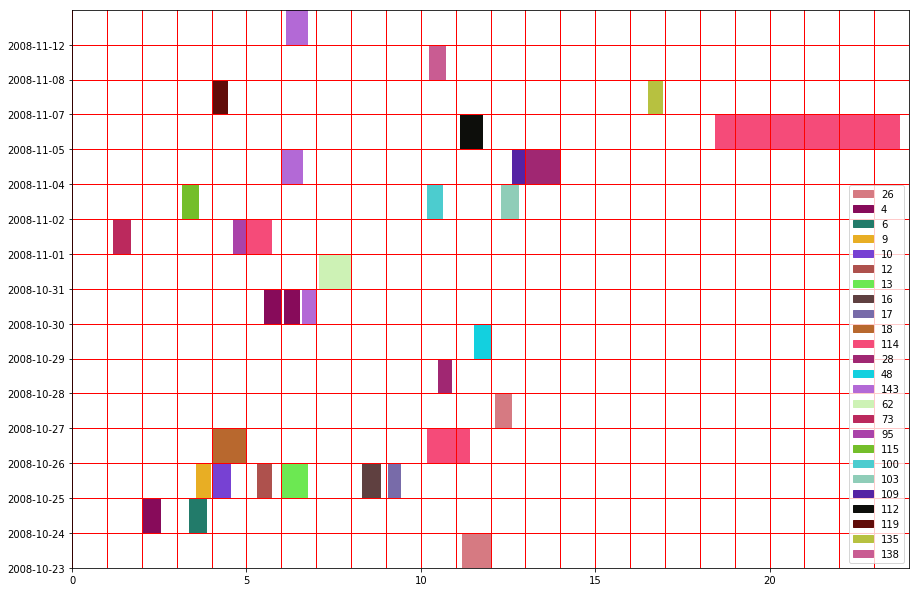

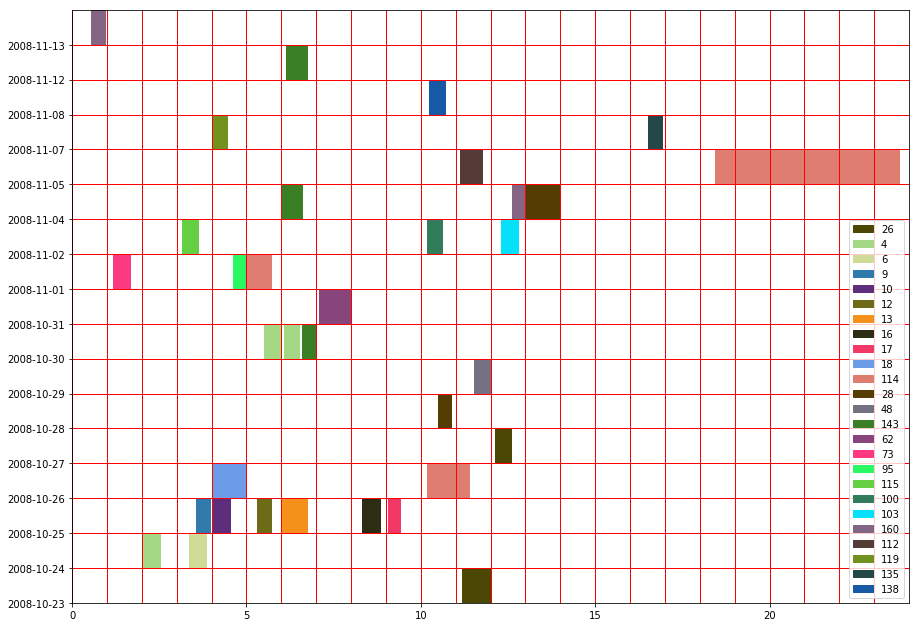

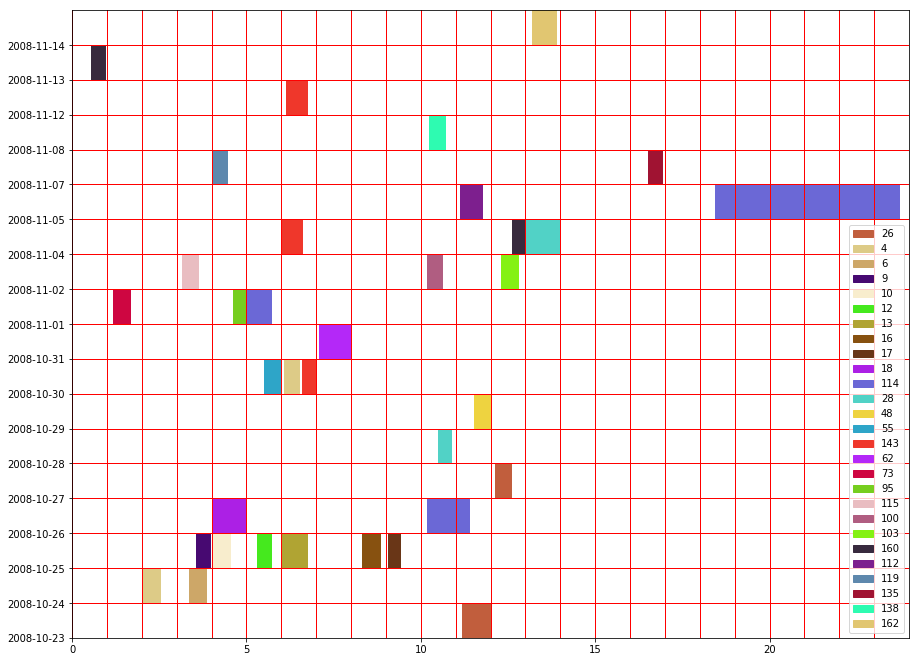

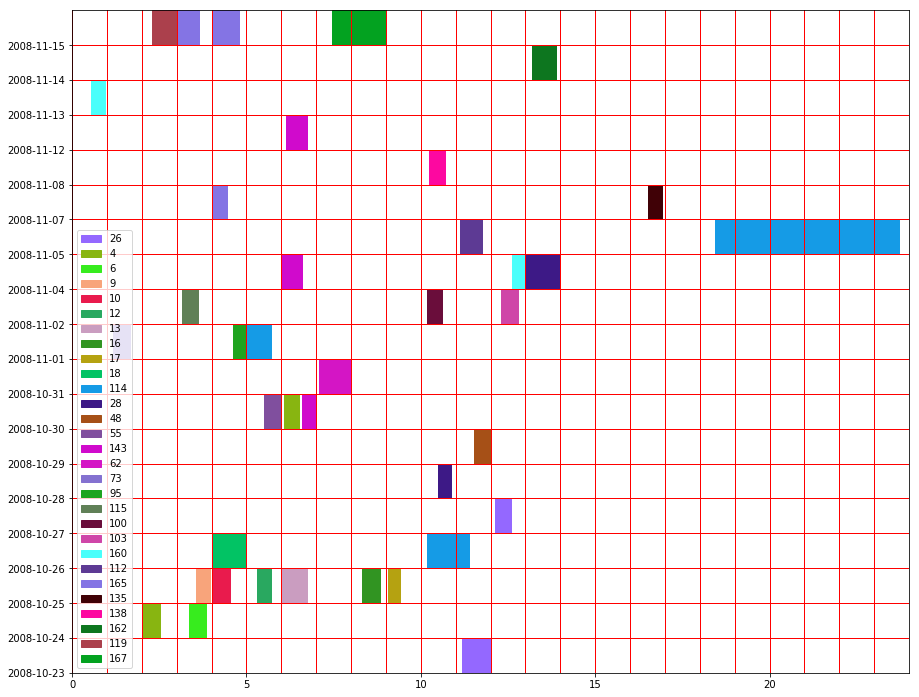

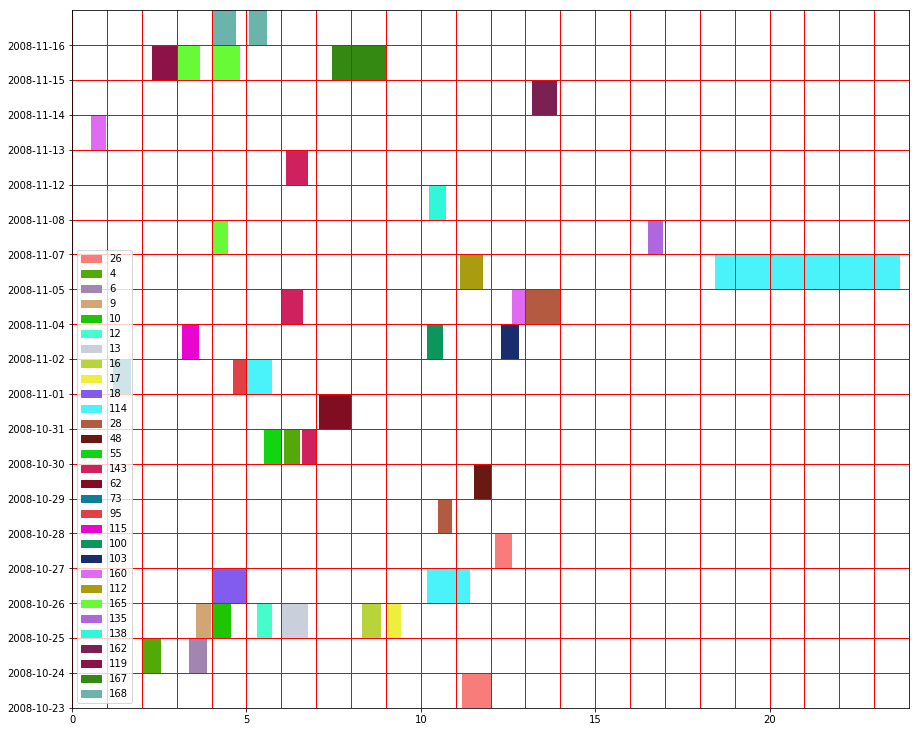

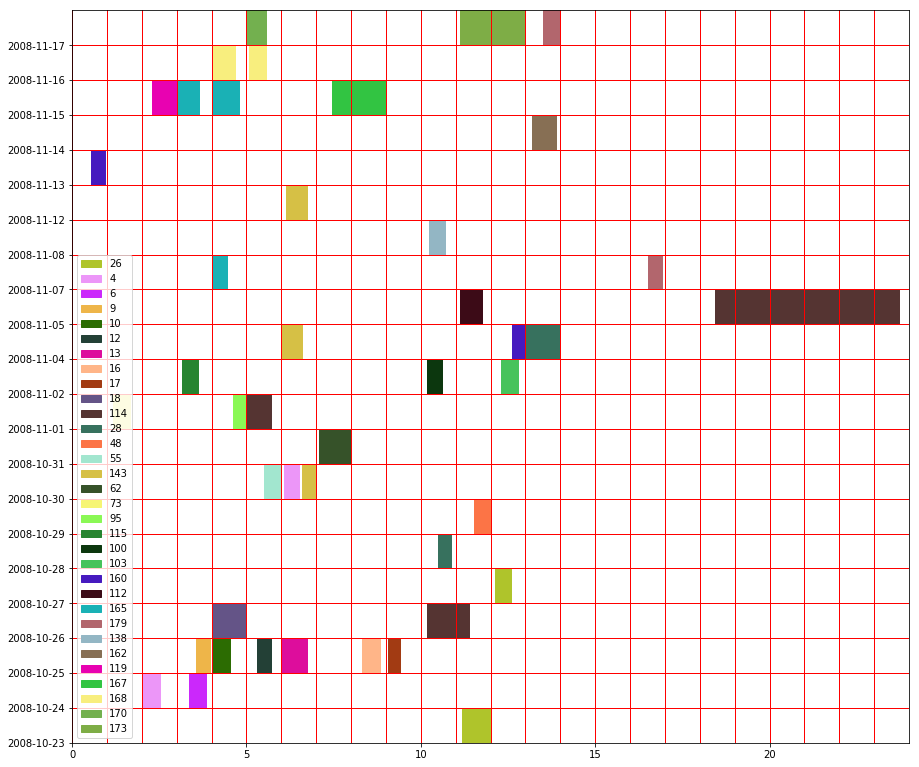

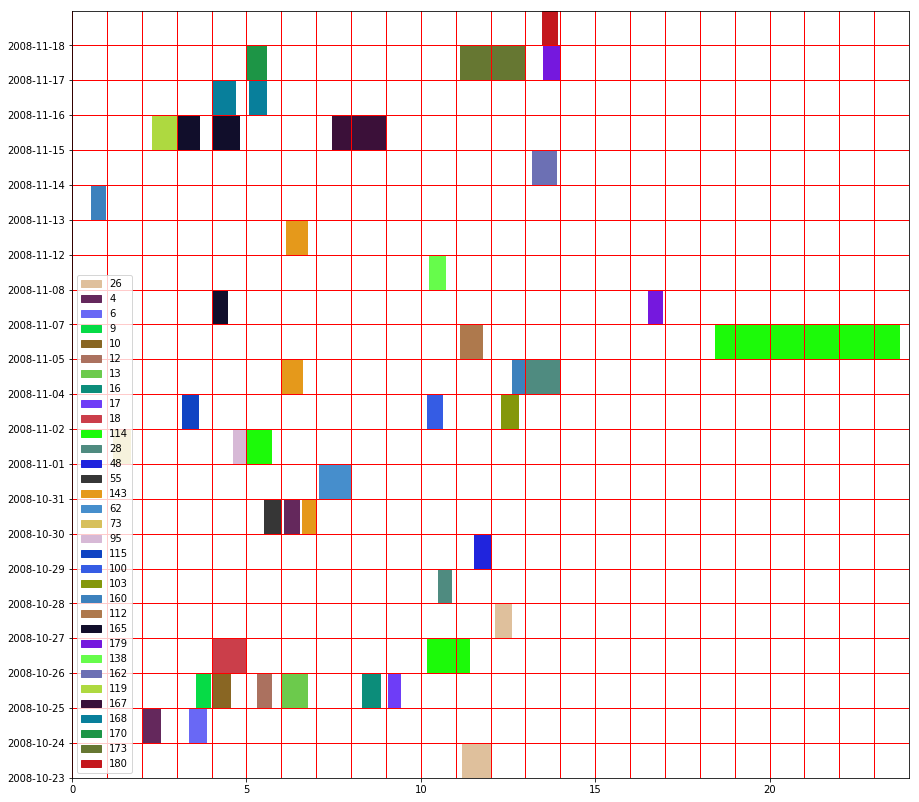

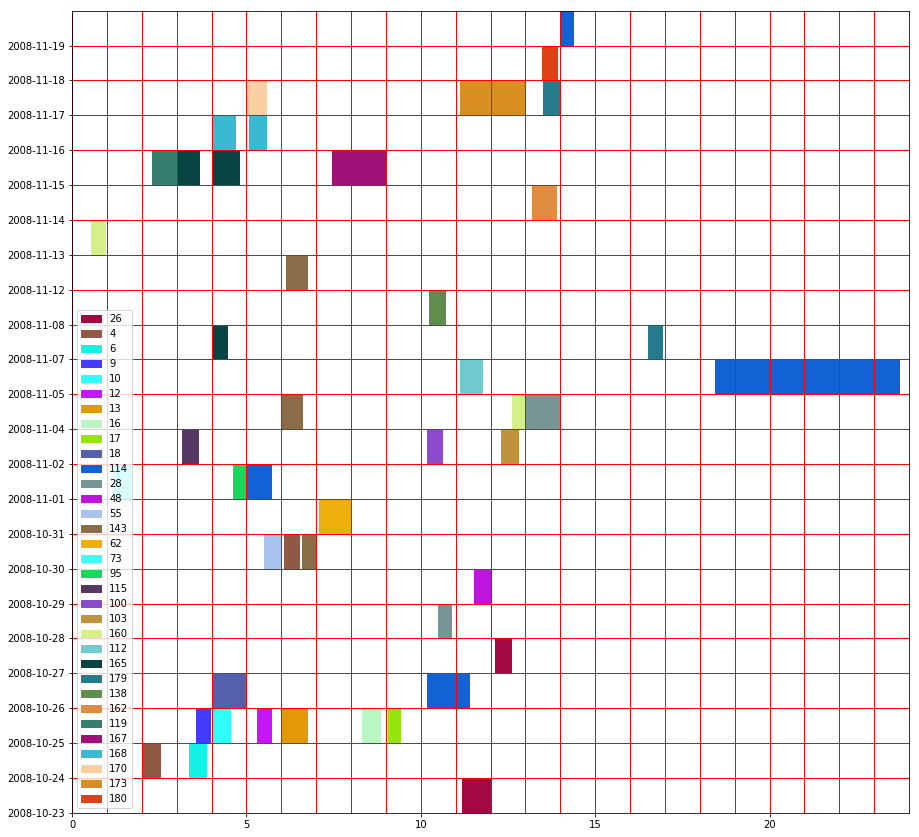

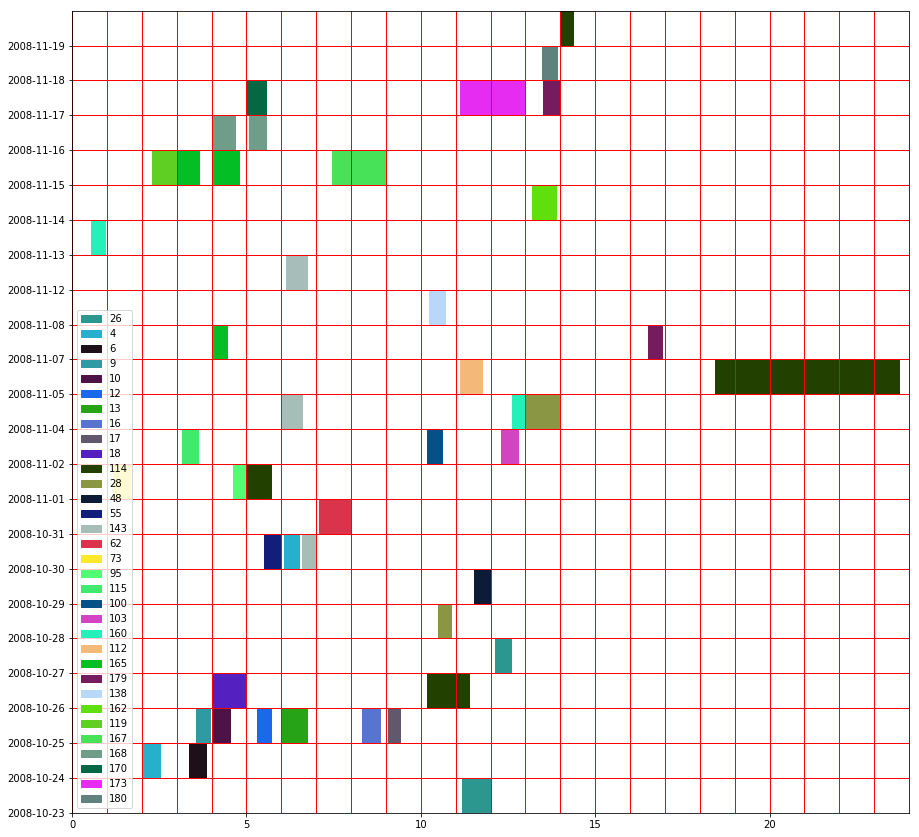

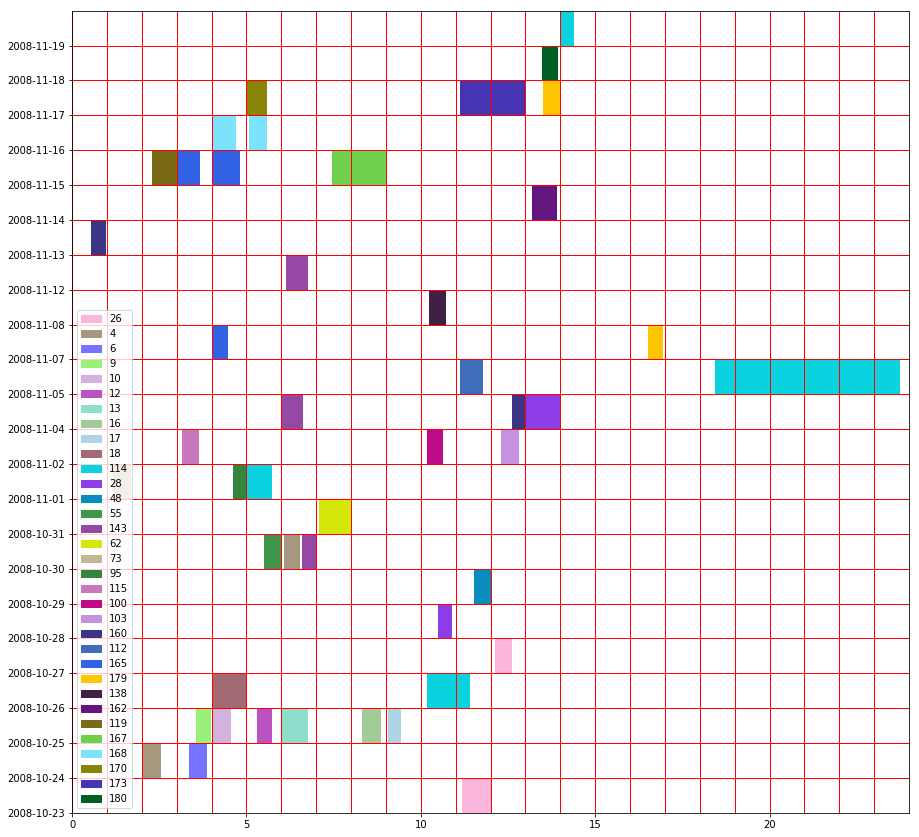

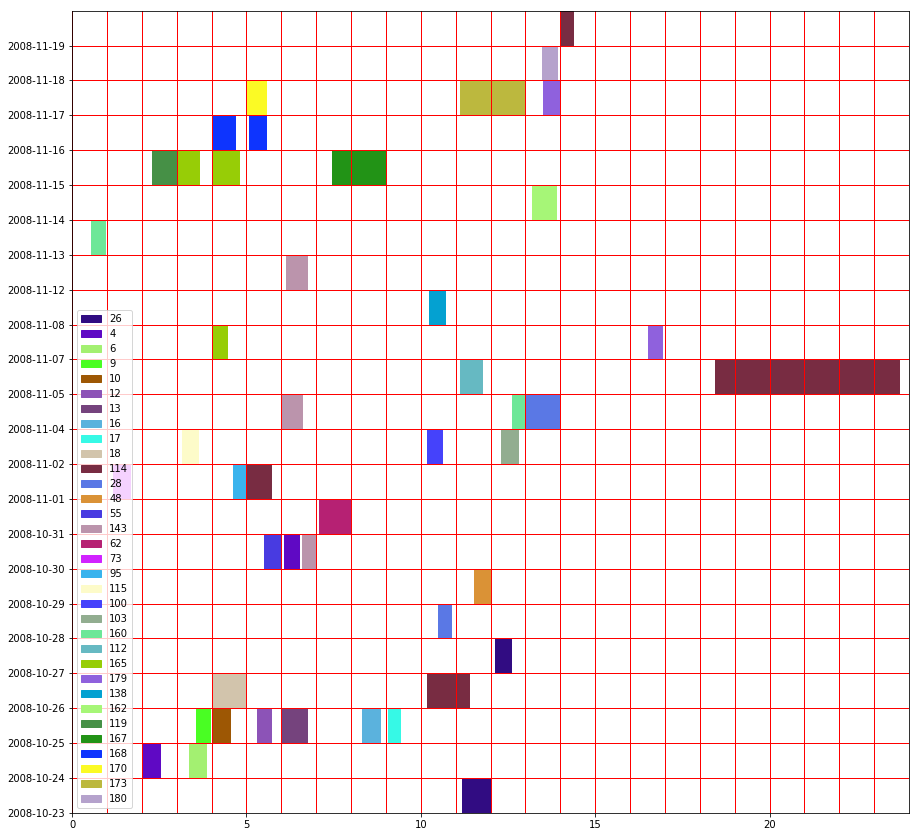

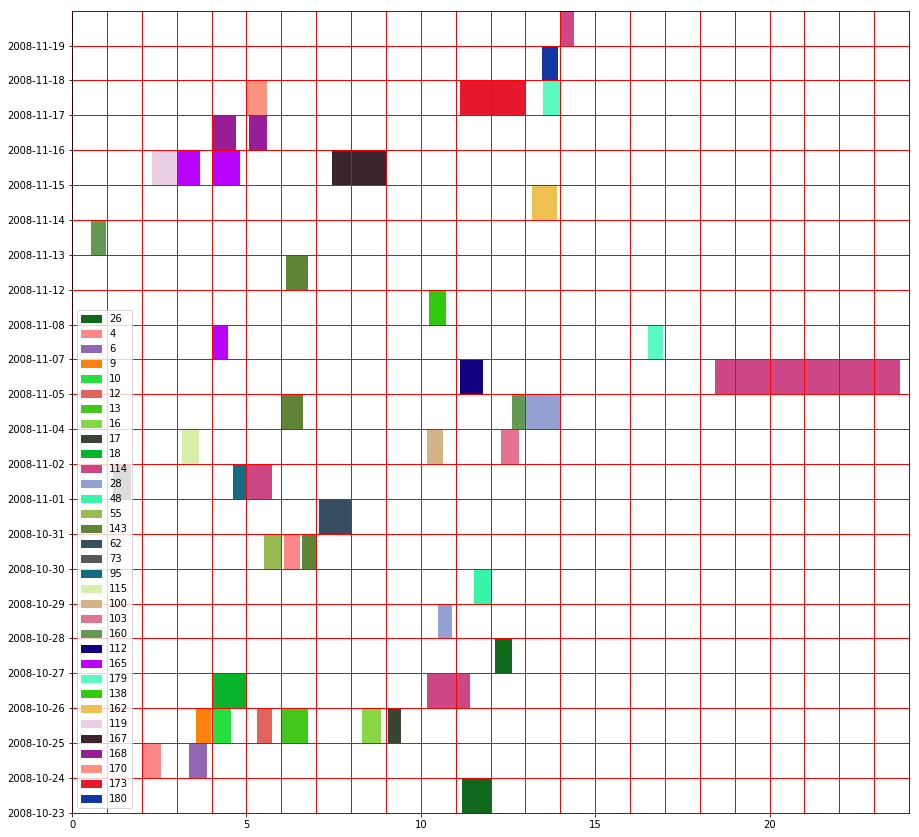

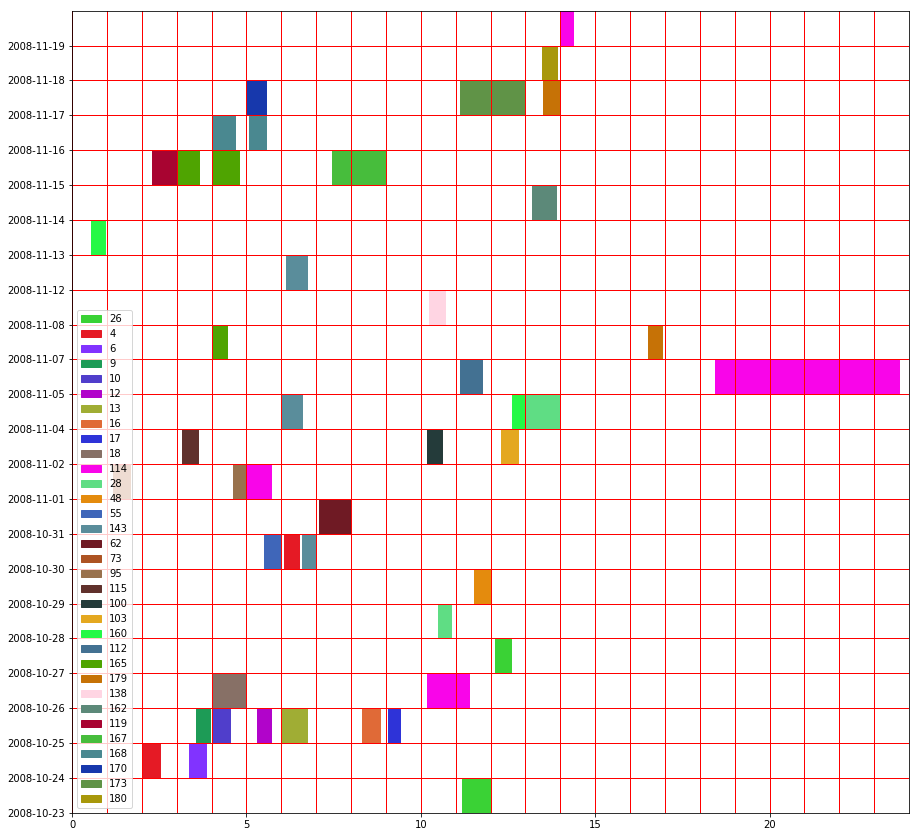

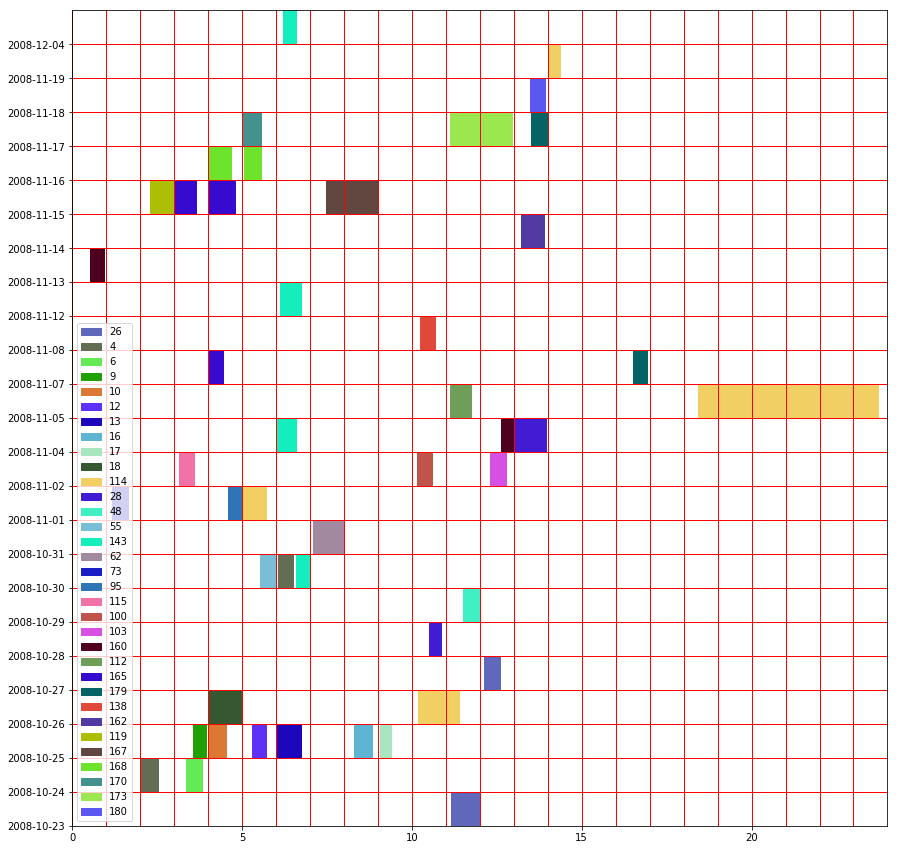

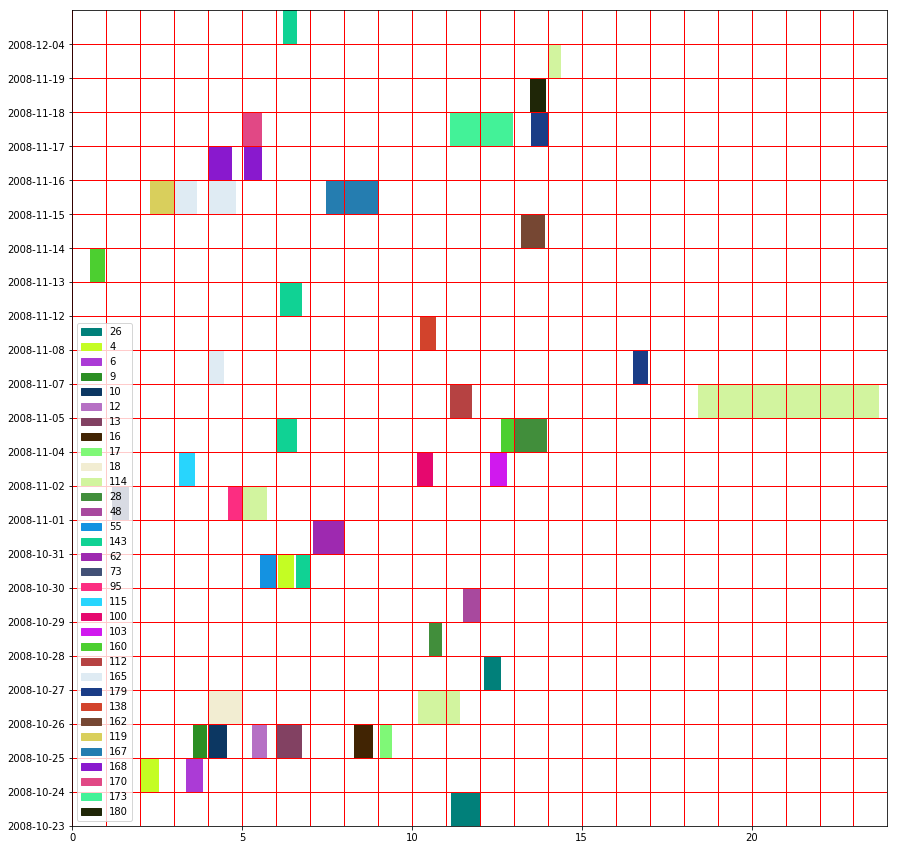

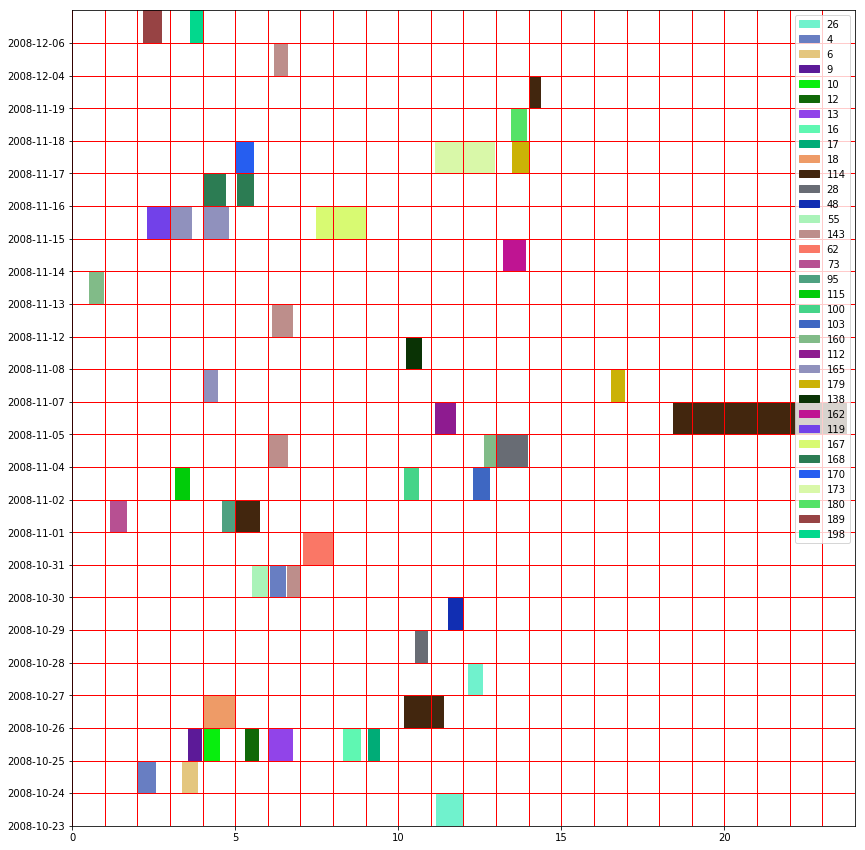

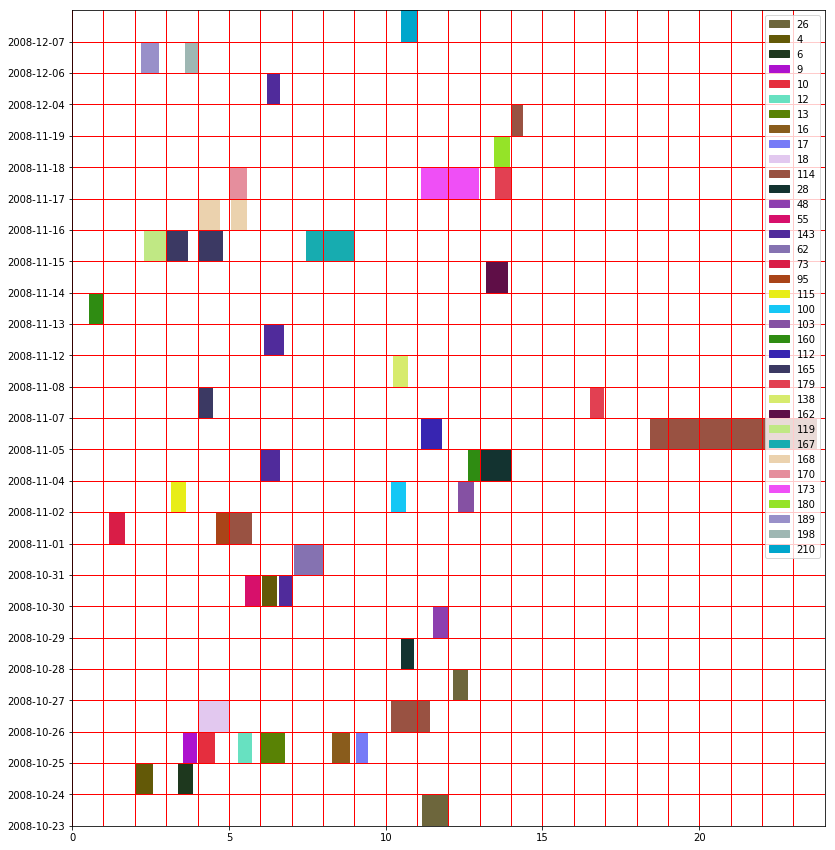

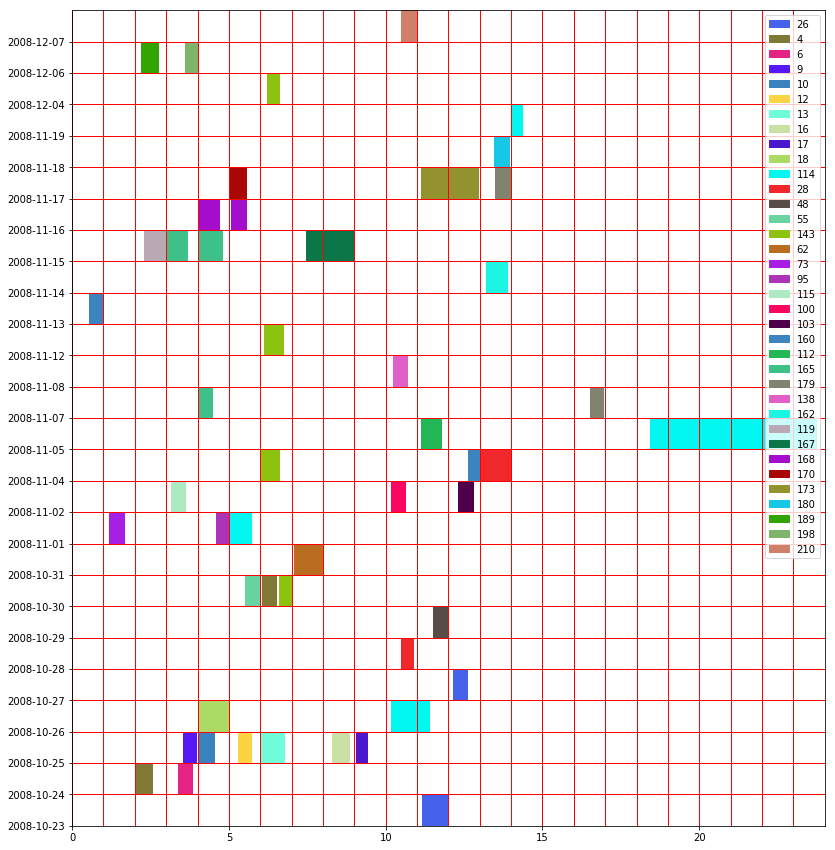

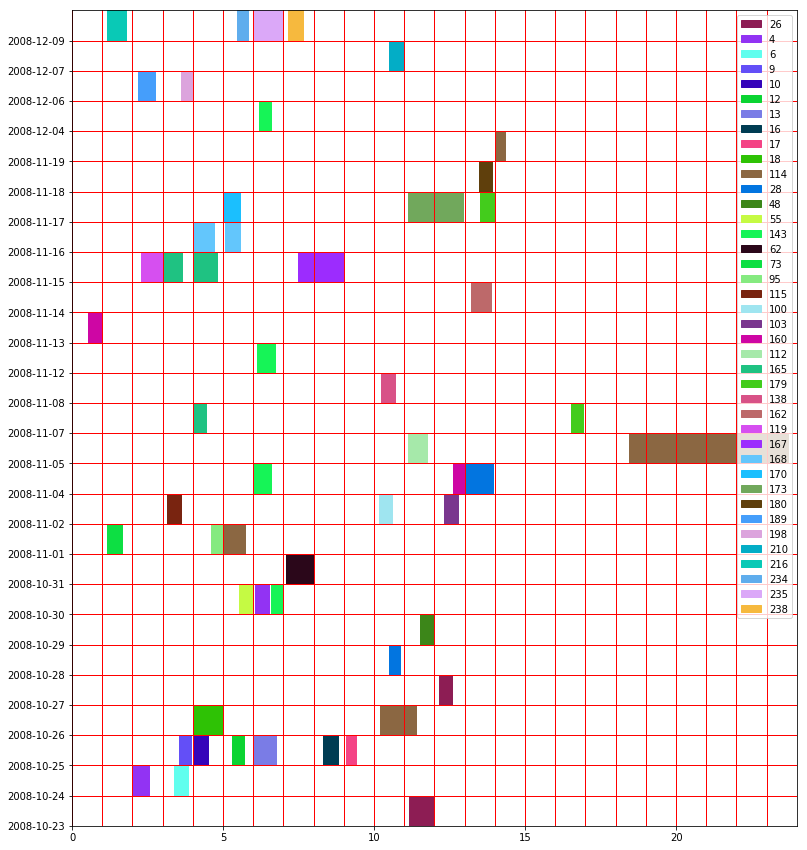

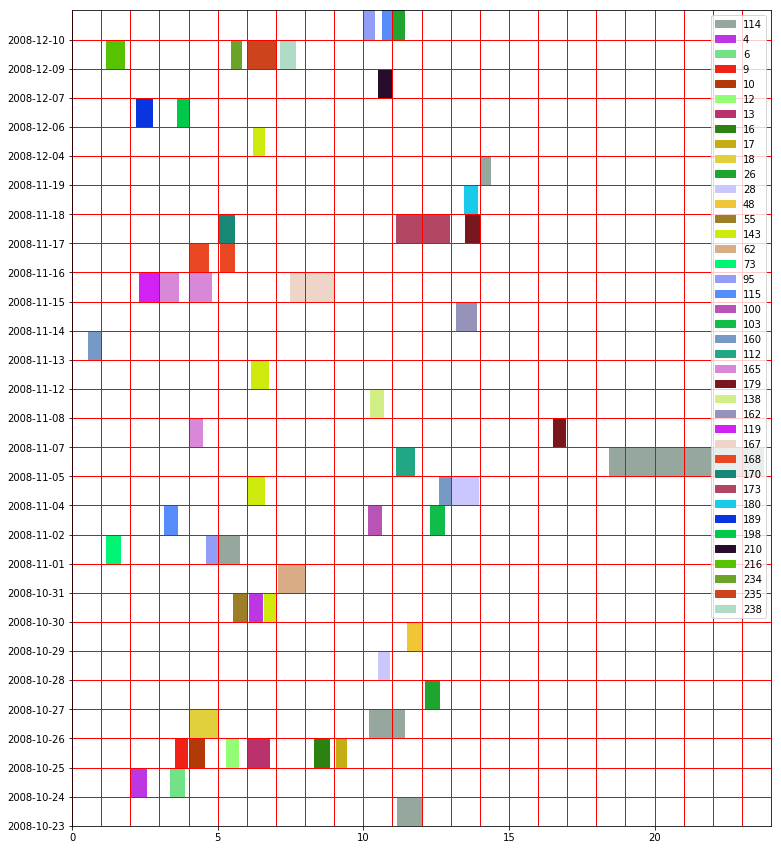

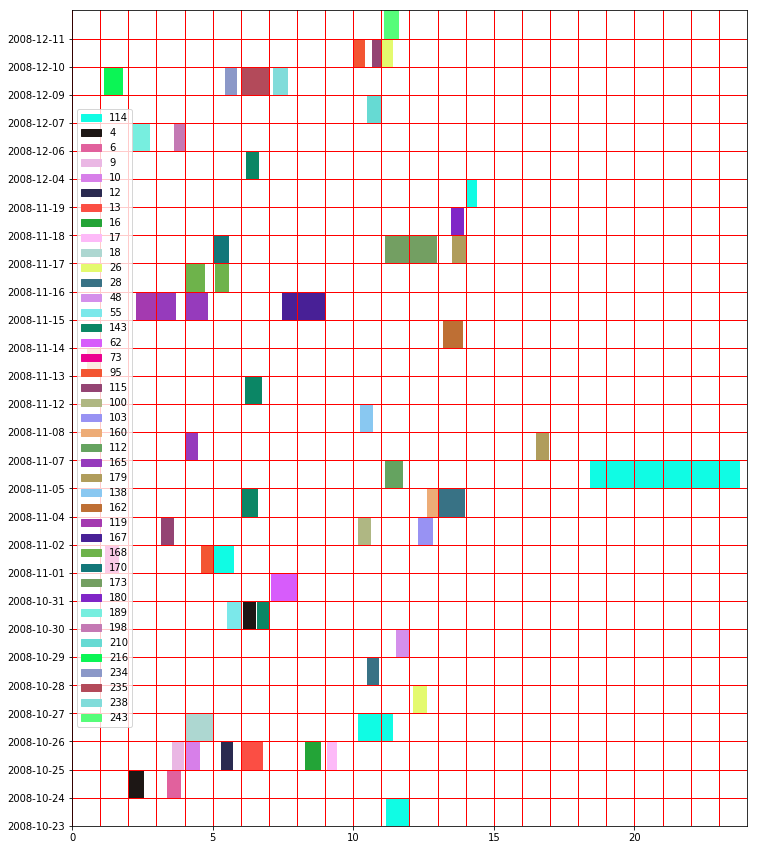

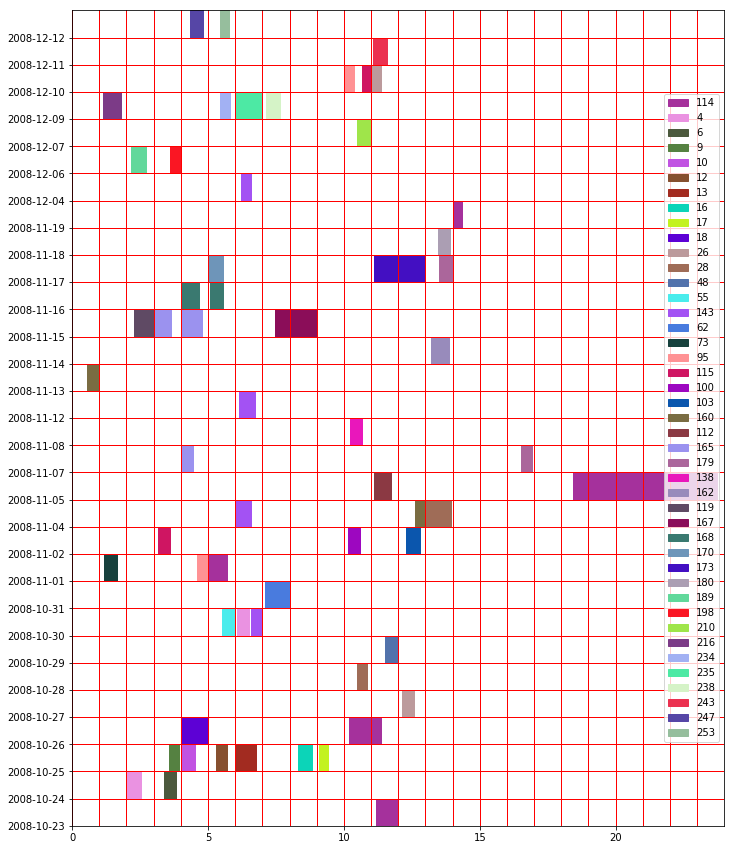

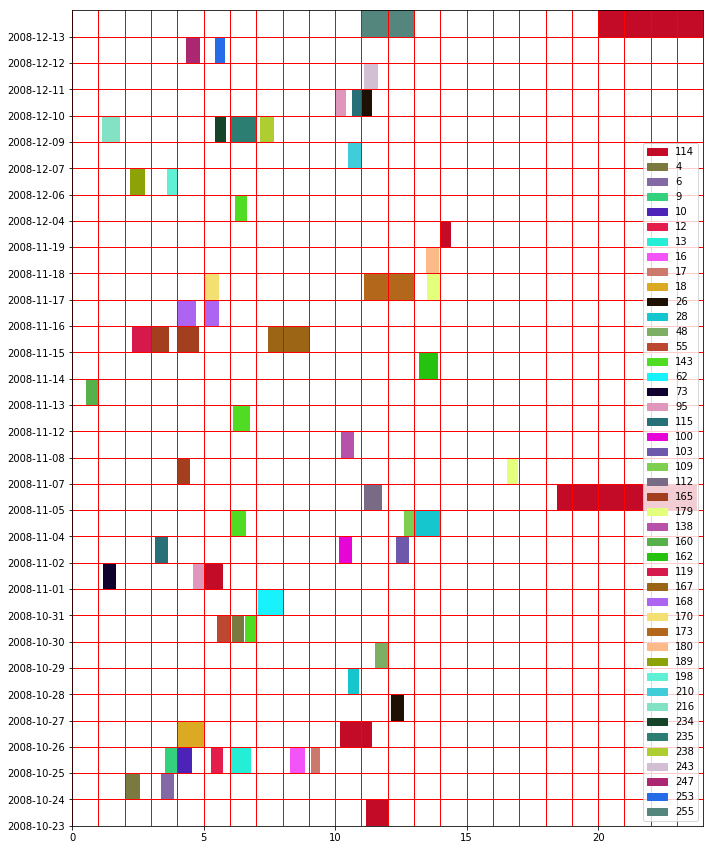

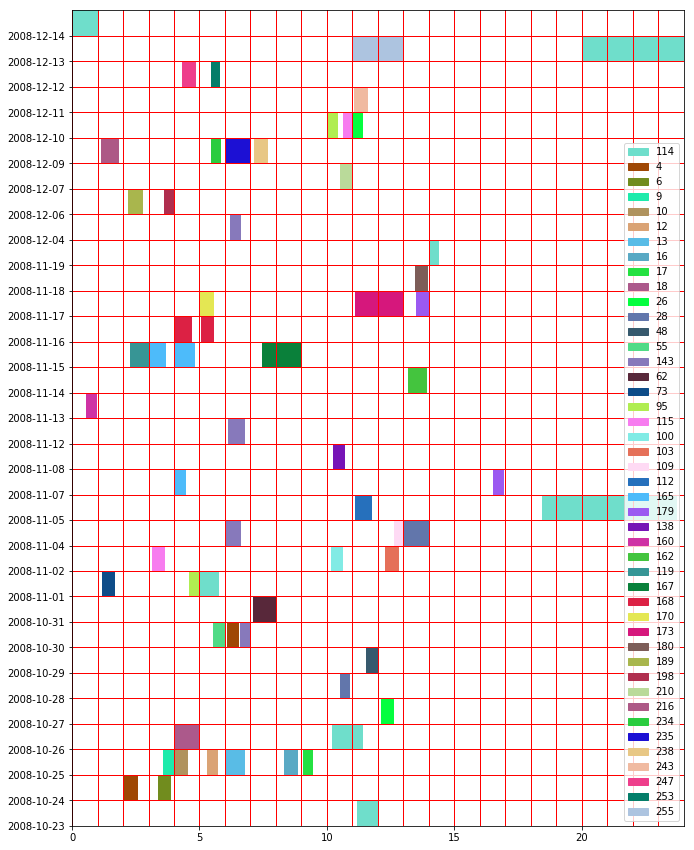

In [3]:
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim

pd.options.mode.chained_assignment = None

#------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df
    
    #Load file names for user
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]
    
    usr_trejec_df.Timestamp = pd.to_datetime(usr_trejec_df.Timestamp)
    
    usr_trejec_df.index = usr_trejec_df['Timestamp']
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()
    
     #add columns to user trajectory dataframe
    #1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    #restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time

    #sort values based on timestamp
    usr_trejec_df = usr_trejec_df.sort_values(['Timestamp'])
    #reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)
    
    #some test columns
    #distance between consicutive points to for further checks
    usr_trejec_df['Distance(Km)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Distance(Km)'] = (meters(usr_trejec_df.loc[i, 'Latitude'],
                                                    usr_trejec_df.loc[i, 'Longitude'],
                                                   usr_trejec_df.loc[i+1, 'Latitude'],
                                                   usr_trejec_df.loc[i+1, 'Longitude'])) / 1000
    #time difference between two points
    usr_trejec_df['Time(Hr)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Time(Hr)'] = (usr_trejec_df.loc[i+1, 'Timestamp'] -
                                              usr_trejec_df.loc[i, 'Timestamp']).seconds/3600
    #speed                                    
    usr_trejec_df['Speed(Km/Hr)'] = usr_trejec_df['Distance(Km)'] / usr_trejec_df['Time(Hr)']
    
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour
    
    #distance clusters
    usr_trejec_df['DistClus'] = 0
    usr_trejec_df['ClusDur'] = 0
    last_hr =  usr_trejec_df['Hour'][0]
    clusid = 0
    i = 0

    while i < len(usr_trejec_df)-1:
        clusid+=1
        
        #update the cluster duration
        if i != 0:
            usr_trejec_df.loc[i-1, 'ClusDur']= (usr_trejec_df.loc[i-1, 'Timestamp'] - 
                                            usr_trejec_df.loc[i-curr_clus_count, 'Timestamp']).seconds/60
        curr_clus_count = 1
        
        #add current cluster to mean values
        array_lat = usr_trejec_df.loc[i,'Latitude']
        array_lon = usr_trejec_df.loc[i,'Longitude']
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)
        
        usr_trejec_df.loc[i, 'DistClus'] = clusid
        for j in range(i+1, len(usr_trejec_df)):
            #if the hour changes, stop j loop
            if usr_trejec_df.loc[j, 'Hour'] != last_hr:
                last_hr =  usr_trejec_df.loc[j, 'Hour']
                i=j
                break
            else:
                if meters(new_lat_mean, 
                           new_lon_mean, 
                           usr_trejec_df.loc[j,'Latitude'], 
                           usr_trejec_df.loc[j,'Longitude'])<= staypts_d_thrhld:
                        curr_clus_count+=1
                        
                        array_lat= np.append(array_lat, usr_trejec_df.loc[j,'Latitude'])
                        array_lon= np.append(array_lon, usr_trejec_df.loc[j,'Longitude'])
                        new_lat_mean = np.mean(array_lat)
                        new_lon_mean = np.mean(array_lon)
        
                        usr_trejec_df.loc[j, 'DistClus'] = usr_trejec_df.loc[i, 'DistClus']
                        
                else:
                    i=j
                    break
        i=j
        

    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df['Timestamp'].dt.weekday_name

    usr_trejec_df['StayPoint'] = -1 # 1 if it is a staypoint, else 0
    usr_trejec_df['StayptId'] = -1
    usr_trejec_df['StayMeanLat'] = -1.0
    usr_trejec_df['StayMeanLon'] = -1.0
    usr_trejec_df['State'] = -1     # 1 if it is a state, else 0
    usr_trejec_df['StateId'] = -1
    usr_trejec_df['StateMeanLat'] = -1.0
    usr_trejec_df['StateMeanLon'] = -1.0
    
    #remove columns not used/required
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis = 1)
    
    file_name = usr_directory + "/input_trj_data.csv"
    usr_trejec_df.to_csv(file_name, sep='\t', encoding='utf-8')
#-------------------------------
def prepare_dfs():
    global cluster_hourly_df    
    
    #create cluster_hourly_df columns
    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['StateId'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0
        
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters


#------------------------------------------------------------------------------------
def cluster(newlat, newlon, row, count):
    global curr_hr_df
    
    currcluster = curr_hr_df['StayptId'][row-1]
    curr_hr_df['StayptId'][row] = -1
    curr_hr_df['StayMeanLat'][row] = -1.0
    curr_hr_df['StayMeanLon'][row] = -1.0
    curr_hr_df['StayPoint'][row] = -1
    clulat = curr_hr_df['StayMeanLat'][row-1]
    clulon = curr_hr_df['StayMeanLon'][row-1]
    
    #if the new point and old point's distance is less than threshold, then add it to current cluster
    if meters(clulat, clulon, newlat, newlon)<= staypts_d_thrhld:
        curr_hr_df['StayptId'][row] = currcluster
        #calculate new mean lat and lon for the cluster
        array_lat = curr_hr_df['Latitude'].loc[curr_hr_df['StayptId'] == currcluster].values
        array_lon = curr_hr_df['Longitude'].loc[curr_hr_df['StayptId'] == currcluster].values
        
        #cal new means
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)
         
        curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayMeanLat'] = new_lat_mean
        curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayMeanLon'] = new_lon_mean
        
#         curr_hr_df['StayMeanLat'] = curr_hr_df.groupby('StayptId')['Latitude'].transform(np.mean)
#         curr_hr_df['StayMeanLon'] = curr_hr_df.groupby('StayptId')['Longitude'].transform(np.mean)
        count = count + 1
        
    #if the new point and old point's distance is greater than threshold, it means the point moved away
    #if the previous cluster has more than two points, check the duration of the previous cluster
    #   if the duration of the previos cluster is greater than threshold, assign it as a staypoint
    
    #if the row read is the last row for this hour
    if (row == len(curr_hr_df)-1):
        if count >= 2:
            MinClusTime = curr_hr_df['Timestamp'][row-count+1]
            MaxClusTime = curr_hr_df['Timestamp'][row]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_t_thrhld):
                curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayPoint'] = 1        
    
    #if the new point is moving away from the cluster
    if meters(clulat, clulon, newlat, newlon)> staypts_d_thrhld:
        if count >= 2:
            MinClusTime = curr_hr_df['Timestamp'][row-count]
            MaxClusTime = curr_hr_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_t_thrhld):
                curr_hr_df.loc[ (curr_hr_df['StayptId']==currcluster), 'StayPoint'] = 1
        count = 1
        curr_hr_df['StayMeanLat'][row] = curr_hr_df['Latitude'][row]
        curr_hr_df['StayMeanLon'][row] = curr_hr_df['Longitude'][row]
        curr_hr_df['StayptId'][row] = currcluster + 1

    return count

#------------------------------------------------------------------------------------
def read_trained_model():
    global trained_model_df
    
    if os.path.isfile(dest_file_final_markov_chain):
        trained_model_df = pd.read_csv(dest_file_final_markov_chain, header = 0, sep="\t")
    
#------------------------------------------------------------------------------------
def create_last_hr_staypts():
    global curr_hr_df          #holds current hour points
    global staypts_df          #holds all staypoints
    global curr_hr_staypts_df  #holds current hour staypoints only
    
    #import pdb; pdb.set_trace()
    #clear current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_staypts_df.iloc[0:0]
    
    #reset index of current hour points
    curr_hr_df = curr_hr_df.reset_index(drop=True)
    
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    if not staypts_df.empty:
        curr_hr_df['StayptId'][row-1] = staypts_df['StayptId'].max() + 1 #assign next possible staypt id
    else:
        curr_hr_df['StayptId'][row-1] = 1 #if this is the start, start from 1 as staypointID
    
    curr_hr_df['StayMeanLat'][row-1] = curr_hr_df['Latitude'][0]
    curr_hr_df['StayMeanLon'][row-1] = curr_hr_df['Longitude'][0]
    curr_hr_df['StayPoint'][row-1] = -1
    
    while row < len(curr_hr_df):
        count = cluster(curr_hr_df['Latitude'][row], curr_hr_df['Longitude'][row], row, count)
        row= row + 1
    
    #copy the staypoints to the current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_df.loc[curr_hr_df['StayPoint'] == 1]
    #copy the stay points into another dataframe
    staypts_df = staypts_df.append(curr_hr_df.loc[curr_hr_df['StayPoint'] == 1])
    #reset staypoints index
    curr_hr_staypts_df.index = curr_hr_staypts_df['Timestamp']
    staypts_df.index = staypts_df['Timestamp']
    #clear current hour dataframe content
    curr_hr_df = curr_hr_df.iloc[0:0]
    
#------------------------------------------------------------------------------------

def cal_hourly_state_weight():
    global curr_hr_staypts_df
    global cluster_hourly_df   
    
    curr_hr_cluster_hourly_df = pd.DataFrame()       
    
    last_hour = curr_hr_staypts_df['Timestamp'][0].hour
    last_clusid = curr_hr_staypts_df['StateId'][0]
    curr_count = 0
    j = 0
    
    for i in range(0, 24):
        curr_hr_cluster_hourly_df['Date'] = 0
        curr_hr_cluster_hourly_df['StateId'] = 0
        curr_hr_cluster_hourly_df['AvgLat'] = 0
        curr_hr_cluster_hourly_df['AvgLon'] = 0
        curr_hr_cluster_hourly_df[i] = 0
    
    for i in range(0, len(curr_hr_staypts_df)):

        if (i == len(curr_hr_staypts_df)-1):
            
            k = curr_hr_staypts_df['Timestamp'][i] - curr_hr_staypts_df['Timestamp'][i-curr_count]
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            date_read = curr_hr_staypts_df.index[i].date()
            cluster_id = curr_hr_staypts_df['StateId'][i]
            ClusterMeanLat = curr_hr_staypts_df['StateMeanLat'][i]
            ClusterMeanLon = curr_hr_staypts_df['StateMeanLon'][i]
            col_name = curr_hr_staypts_df.index[i].hour

            curr_hr_cluster_hourly_df.loc[j,'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j,'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j,'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j,'StateId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            
        if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour) | (curr_hr_staypts_df['StateId'][i] != last_clusid):
            #import pdb; pdb.set_trace()

            if (curr_count == 1) & (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                k = ((curr_hr_staypts_df['Timestamp'][i-1] + pd.Timedelta(hours=1) - 
                      pd.Timedelta(minutes=curr_hr_staypts_df['Timestamp'][i-1].minute)) - 
                     curr_hr_staypts_df['Timestamp'][i-1])
            else:
                k = curr_hr_staypts_df['Timestamp'][i-1] - curr_hr_staypts_df['Timestamp'][i-curr_count]

            l = (k / np.timedelta64(1, 'm')).astype(int)
            date_read = curr_hr_staypts_df.index[i-1].date()
            cluster_id = curr_hr_staypts_df['StateId'][i-1]
            ClusterMeanLat = curr_hr_staypts_df['StateMeanLat'][i-1]
            ClusterMeanLon = curr_hr_staypts_df['StateMeanLon'][i-1]
            col_name = curr_hr_staypts_df.index[i-1].hour

            curr_hr_cluster_hourly_df.loc[j, 'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j, 'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j, 'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j, 'StateId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            j = j + 1
            curr_count = 1

            if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = curr_hr_staypts_df['Timestamp'][i].hour
            if (curr_hr_staypts_df['StateId'][i] != last_clusid):
                last_clusid = curr_hr_staypts_df['StateId'][i]
        else:
            curr_count = curr_count + 1

    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.fillna(0)
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.groupby(['Date', 'StateId', 'AvgLat', 'AvgLon']).sum()
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.reset_index(level=[0,1,2,3])
   
    cluster_hourly_df = cluster_hourly_df.append(curr_hr_cluster_hourly_df, ignore_index=True)
    cluster_hourly_df = cluster_hourly_df.reset_index(drop=True)
    
#-------------form states-----------------------------------------------------------------------
def form_states():
    global staypts_df
    global curr_hr_staypts_df
    
    #update states in final staypoints
    #copy staypoint data as state data
    staypts_df['StateId'] = staypts_df['StayptId']
    staypts_df['StateMeanLat'] = staypts_df['StayMeanLat']
    staypts_df['StateMeanLon'] = staypts_df['StayMeanLon']
    
    #this fucntion groups the staypoints together to from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['StateId', 'StateMeanLat', 'StateMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['StateMeanLat', 'StateMeanLon'])
    staypts_df1 = staypts_df1.reset_index(drop=True)
    
    row = 1

    for i in range(0, len(staypts_df1)-1):
        for j in range(i+1, len(staypts_df1)):
        
            chk_cluster = staypts_df1['StateId'][i]
            chk_clulat = staypts_df1['StateMeanLat'][i]
            chk_clulon = staypts_df1['StateMeanLon'][i]
            curr_cluster = staypts_df1['StateId'][j]
            curr_clulat = staypts_df1['StateMeanLat'][j]
            curr_clulon = staypts_df1['StateMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                #before adding this point to the ith state, 
                #   calculate new mean with jth point,
                #   if the new mean is still keeping all the states with id(i) than add jth to the state
                #   else not
                
                add_state = "Yes"
                #form the existing lat and lon array
                array_lat = staypts_df['Latitude'].loc[staypts_df['StateId'] == chk_cluster].values
                array_lon = staypts_df['Longitude'].loc[staypts_df['StateId'] == chk_cluster].values
                #add the new lat and lon values to the array
                new_lats = staypts_df['Latitude'].loc[staypts_df['StateId'] == curr_cluster].values
                new_lons = staypts_df['Longitude'].loc[staypts_df['StateId'] == curr_cluster].values
                
                array_lat= np.append(array_lat, new_lats)
                array_lon= np.append(array_lon, new_lons)
                #cal new means
                new_lat_mean = np.mean(array_lat)
                new_lon_mean = np.mean(array_lon)
                
                for k in range(0, len(array_lat)):
                    if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                        add_state = "No"
                        
                if add_state == "Yes":    
                    staypts_df.loc[ (staypts_df['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLat'] = new_lat_mean
                    staypts_df.loc[ (staypts_df['StateId']==chk_cluster), 'StateMeanLon'] = new_lon_mean
            else:
                break
                
    #update states for last hour staypoints
    #copy staypoint data as state data
     #copy staypoint data as state data
    curr_hr_staypts_df['StateId'] = curr_hr_staypts_df['StayptId']
    curr_hr_staypts_df['StateMeanLat'] = curr_hr_staypts_df['StayMeanLat']
    curr_hr_staypts_df['StateMeanLon'] = curr_hr_staypts_df['StayMeanLon']
    
    #this fucntion groups the staypoints together to from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    curr_hr_staypts_df1 = curr_hr_staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon']].copy()
    curr_hr_staypts_df1 = curr_hr_staypts_df1.drop_duplicates(subset=['StateId', 'StateMeanLat', 'StateMeanLon'])

    curr_hr_staypts_df1 = curr_hr_staypts_df1.sort_values(['StateMeanLat', 'StateMeanLon'])
    curr_hr_staypts_df1 = curr_hr_staypts_df1.reset_index(drop=True)
    
    row = 1

    for i in range(0, len(curr_hr_staypts_df1)):
        for j in range(i+1, len(curr_hr_staypts_df1)):
        
            chk_cluster = curr_hr_staypts_df1['StateId'][i]
            chk_clulat = curr_hr_staypts_df1['StateMeanLat'][i]
            chk_clulon = curr_hr_staypts_df1['StateMeanLon'][i]
            curr_cluster = curr_hr_staypts_df1['StateId'][j]
            curr_clulat = curr_hr_staypts_df1['StateMeanLat'][j]
            curr_clulon = curr_hr_staypts_df1['StateMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= state_d_thrhld:
                #before adding this point to the ith state, 
                #   calculate new mean with jth point,
                #   if the new mean is still keeping all the states with id(i) than add jth to the state
                #   else not
                
                add_state = "Yes"
                #form the existing lat and lon array
                array_lat = curr_hr_staypts_df['Latitude'].loc[curr_hr_staypts_df['StateId'] == chk_cluster].values
                array_lon = curr_hr_staypts_df['Longitude'].loc[curr_hr_staypts_df['StateId'] == chk_cluster].values
                #add the new lat and lon values to the array
                new_lats = curr_hr_staypts_df['Latitude'].loc[curr_hr_staypts_df['StateId'] == curr_cluster].values
                new_lons = curr_hr_staypts_df['Longitude'].loc[curr_hr_staypts_df['StateId'] == curr_cluster].values
                
                array_lat= np.append(array_lat, new_lats)
                array_lon= np.append(array_lon, new_lons)
                #cal new means
                new_lat_mean = np.mean(array_lat)
                new_lon_mean = np.mean(array_lon)
                
                for k in range(0, len(array_lat)):
                    if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                        add_state = "No"
                        
                if add_state == "Yes":    
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateId'] = chk_cluster
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateMeanLat'] = new_lat_mean
                    curr_hr_staypts_df.loc[ (curr_hr_staypts_df['StateId']==curr_cluster), 'StateMeanLon'] = new_lon_mean
            else:
                break
                
#------------------------------------------------------------------------------------------------
def visualize_hourly_state_weight():
    global staypts_df
    
    #create a color dictionary for each cluster for the plot
    dicts = {}
    clu_list = []
    clu_list = staypts_df['StateId'].unique()
    r = lambda: random.randint(0,255)
    #olors = sns.color_palette("Paired", len(clu_list))
    
    for i in range(0, len(clu_list)):
        #icts[clu_list[i]] = (colors[i])
        dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))
        
    #create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(15,15))
    ax1 = fig2.add_subplot(111, aspect='equal')

    #get all the dates for y axis
    date_list = staypts_df['Timestamp'].dt.date.unique()
    y = range(0, len(date_list))
    def_yticks = date_list
    plt.yticks(y, def_yticks)
    
    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_list))

    date_counter = 0
    last_date = staypts_df['Timestamp'][0].date()
    last_hour = staypts_df['Timestamp'][0].hour
    last_clusid = staypts_df['StateId'][0]
    curr_count = 0
    j = 0
    
    #drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')

    for i in range(0, len(staypts_df)):
        #import pdb; pdb.set_trace()
        
        if (i == len(staypts_df)-1):
            a = staypts_df['Timestamp'][i-curr_count].hour + staypts_df['Timestamp'][i-curr_count].minute/60
            b = staypts_df['Timestamp'][i].hour + staypts_df['Timestamp'][i].minute/60
            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=staypts_df['StateId'][i]))
            
        #plot a rectangle if the hour or stateid or date has changed
        if ((staypts_df['Timestamp'][i].hour != last_hour) | (staypts_df['StateId'][i] != last_clusid)
           | (last_date != staypts_df['Timestamp'][i].date())):

            if (curr_count == 1) & (staypts_df['Timestamp'][i].hour != last_hour):
                a = staypts_df['Timestamp'][i-curr_count].hour + 1
            else:
                a = staypts_df['Timestamp'][i-curr_count].hour + staypts_df['Timestamp'][i-curr_count].minute/60

            b = staypts_df['Timestamp'][i-1].hour + staypts_df['Timestamp'][i-1].minute/60

            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['StateId'][i-1])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=staypts_df['StateId'][i-1]))

            curr_count = 1

            if (staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = staypts_df['Timestamp'][i].hour
            if (staypts_df['StateId'][i] != last_clusid):
                last_clusid = staypts_df['StateId'][i]
            if (last_date != staypts_df['Timestamp'][i].date()):
                date_counter = date_counter + 1
                last_date = staypts_df['Timestamp'][i].date()
                ax1.axhline(y= date_counter, linewidth=1, color='r')

        else:
            curr_count = curr_count + 1
            
    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()
#-----------------------------------------------------------------------------------
def update_staypts_csv():
     with open(dest_file_staypoints, 'a') as f:
             (staypts_df).to_csv(f,  sep='\t', encoding='utf-8')
#-----------------------------------------------------------------------------------
def update_hourly_weights_csv():
    with open(dest_file_hourly_weights, 'a') as f:
             (cluster_hourly_df).to_csv(f,  sep='\t', encoding='utf-8')
#------------------------------------------------------------------------------------
def create_save_seperate_trasition_matrices():
    date_list = cluster_hourly_df['Date'].unique()
    
    #create a temp dataframe for each data, and calculate trasition matrices from hour t to t+1
    for p in range(0, cluster_hourly_df['Date'].nunique()):

        #create a temp dataframe for pervious date
        temp_df = pd.DataFrame()
        matrices_df = pd.DataFrame()
        temp_df = cluster_hourly_df.loc[cluster_hourly_df['Date'] == date_list[p]]
        temp_df = temp_df.reset_index(drop=True)

        for i in range(0, 24):
            matrices_df['Date'] = 0
            matrices_df['StateId'] = 0
            for j in range(0, len(temp_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['StateId'][j])
                matrices_df[colname] = 0

        matrices_df['Date'] = temp_df['Date']
        matrices_df['StateId'] = temp_df['StateId']

        for i in range (0, 23):
            for j in range (0, len(temp_df)):
                for k in range (0, len(temp_df)):
                    prob = temp_df[i][j] * temp_df[i+1][k]
                    colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['StateId'][k])
                    matrices_df[colname][j] = prob
        file_name = dest_path_each_day_trsn_mat + str(date_list[p]) + ".csv"
        matrices_df.to_csv(file_name, sep='\t', encoding='utf-8')

#------------------------------------------------------------------------------------
def create_save_markov_chains():
    global final_transition_df
    global co_loc
    
    final_transition_df = pd.DataFrame()
    
    #create an empty markov chain frame for each state, and transition for each hour of the day
    date_list = cluster_hourly_df['Date'].unique()
    cluster_list = cluster_hourly_df['StateId'].unique()
    AvgLat_list = cluster_hourly_df['AvgLat'].unique()
    AvgLon_list = cluster_hourly_df['AvgLon'].unique()
    
    for i in range(0, 24):
        final_transition_df['Address'] = 0
        final_transition_df['AvgLat'] = 0
        final_transition_df['AvgLon'] = 0
        final_transition_df['StateId'] = 0
        for j in range(0, cluster_hourly_df['StateId'].nunique()):
            colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(cluster_list[j])
            final_transition_df[colname] = 0
          
    final_transition_df['StateId'] = cluster_list
    final_transition_df['AvgLat'] = AvgLat_list
    final_transition_df['AvgLon'] = AvgLon_list
    final_transition_df = final_transition_df.fillna(0)
    final_transition_df.index = final_transition_df.StateId

    #read each day file and sum the matching rows:cols combinations
    date_list = cluster_hourly_df['Date'].unique()
    path_dir = dest_path_each_day_trsn_mat

    
    for p in range(0, cluster_hourly_df['Date'].nunique()):
        temp_df = pd.DataFrame()
        filename = path_dir + str(date_list[p]) + '.csv'
        temp_df =  pd.read_csv(filename, header = 0, sep='\t')

        for i in range(0, len(temp_df)):
            rowname = temp_df['StateId'][i]
            for src_column in temp_df:
                for dest_column in final_transition_df:
                    if src_column == dest_column and src_column != 'StateId' :
                        #import pdb; pdb.set_trace()
                        final_transition_df[dest_column][rowname] = (final_transition_df[dest_column][rowname] +
                                                                    temp_df[src_column][i])

    #calculate probability from cluster x to cluster y from time t to t+1
    final_transition_df = final_transition_df.reset_index(drop=True)
    for clus in range(0, len(final_transition_df)):
        for i in range(0, 24):
            temp_sum = 0
            for j in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['StateId'][j])
                temp_sum += (final_transition_df[colname][clus])
            for k in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['StateId'][k])
                if temp_sum != 0:
                    final_transition_df[colname][clus] = final_transition_df[colname][clus]/temp_sum
    
    #create dictionary for coordinate : address
    points = tuple(zip(final_transition_df.AvgLat, final_transition_df.AvgLon))
    geocoder = Nominatim(timeout=10)
    coordinate_location = {}
    
    for coordinate in points:
        try:
            location = geocoder.reverse(coordinate)
        except:
            location = 'unknown'
        coordinate_location[coordinate] = location
    
    co_loc = {k:v for k,v in coordinate_location.items()}

    for i in range(0, len(final_transition_df)):
        address = co_loc.get((final_transition_df['AvgLat'][i], final_transition_df['AvgLon'][i]))
        if address == 'unknown':
            final_transition_df['Address'][i] = 'unknown'
        else:
            final_transition_df['Address'][i] = address[0]
    
    #replace zero probabilities to a small value and save the file
    final_transition_df = final_transition_df.fillna(0)                    
    final_transition_df = final_transition_df.replace(0, 0.00001)
    final_transition_df.to_csv(dest_file_final_markov_chain, sep='\t')
    
    for i in range(0, 24):
        final_transition_temp_df = pd.DataFrame()
        k = cluster_hourly_df['StateId'].nunique()*i + 4
        final_transition_temp_df = final_transition_df.iloc[:,k:k + cluster_hourly_df['StateId'].nunique()]
        final_transition_temp_df.index = cluster_list
        file_name = usr_markov_chains_directory + "/" + str(i) + " hour.csv"
        final_transition_temp_df.to_csv(file_name, sep='\t', encoding='utf-8')
        
        
#------------------------------------------------------------------------------------
def predict(new_hour):
    global trained_model_df
    global curr_hr_staypts_df
    
    tobepredicted_df = curr_hr_staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon', 'Timestamp']]
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    for j in range(0, len(tobepredicted_df)):
        new_lat = tobepredicted_df['StateMeanLat'][j]
        new_lon = tobepredicted_df['StateMeanLon'][j]
        file_name = "Predicted Timestamp - " +  str(tobepredicted_df['Timestamp'][j]) + ".csv"
        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            if meters(trn_lat, trn_lon, new_lat, new_lon) <= 10000:

                predic_df = pd.DataFrame()

                cluster_id = trained_model_df['StateId'][i]
                curr_lat = trained_model_df['AvgLat'][i]
                curr_lon = trained_model_df['AvgLon'][i]
                curr_add = trained_model_df['Address'][i]
                pred_loc = {"current":(cluster_id, curr_lat, curr_lon, curr_add)}

                from_col_no = trained_model_df['StateId'].nunique() * new_hour + 5
                to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                predic_df = trained_model_df.iloc[i:i+1,from_col_no:to_col_no]
                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['SelectedState'] = predic_df.index
                predic_df['SelectedState'] = predic_df['SelectedState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'SelectedState']
                predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for j in range (0, len(predic_df)):
                    #import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['SelectedState'][j]))
                    add = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[ (trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[j, 'Address'] = add
                    predic_df.loc[j, 'Latitude'] = lat
                    predic_df.loc[j, 'Longitude'] = lon
                file = dest_predicted_dir + file_name
                predic_df.to_csv(file, sep='\t', encoding='utf-8')
                break
            
#------------------------------------------ S T A R T -----------------------------------------------
#global dataframes used
#user raw trajectory dataframe
usr_trejec_df = pd.DataFrame()
#user trained model
trained_model_df = pd.DataFrame()
#current hour points
curr_hr_df = pd.DataFrame()
#current hour staypoints
curr_hr_staypts_df = pd.DataFrame()
#all staypoints
staypts_df = pd.DataFrame()
#hourly cluster
cluster_hourly_df = pd.DataFrame()
#final markov chains
final_transition_df = pd.DataFrame()

clus_dict = {}
co_loc = {}
pred_loc = {}
lat_array = []
lon_array = []
global_count = 0

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#Edit user name, and path locations for source and destination files
user = "001"
state_d_thrhld = 200
staypts_d_thrhld = 200
staypts_t_thrhld = 20

#destination paths
usr_directory = "/home/shashank/Documents/location/code/stay points/v0.4 results/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/code/stay points/v0.4 results/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/code/stay points/v0.4 results/User " + user + "/staypoints"
usr_markov_chains_directory = "/home/shashank/Documents/location/code/stay points/v0.4 results/User " + user + "/markovchains"
dest_predicted_dir = "/home/shashank/Documents/location/code/stay points/v0.4 results/User " + user + "/predict/"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)  
if not os.path.exists(usr_markov_chains_directory):
    os.makedirs(usr_markov_chains_directory)  
if not os.path.exists(dest_predicted_dir):
    os.makedirs(dest_predicted_dir)  

#destination file names
dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"
dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

#remove if the file already exists
try:
    os.remove(dest_file_staypoints)
    os.remove(dest_file_hourly_weights)
    os.remove(dest_file_final_markov_chain)
except OSError:
    pass

#source paths
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/2008*.plt" 

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#read test user trajectory file. In real scenerio, this will be the GPS read data
read_usr_file()

#prepere dataframes
prepare_dfs()

#Save first date and time as prev date and time for the start
prev_date = usr_trejec_df['Date'][0]
prev_hour = usr_trejec_df['Hour'][0]

#I. Read the new locations in an online gps location input mode
#  1. Everytime the hour changes, 
#                  A. Find staypoints for the last hour and assign staypointID
#                  B. Cluster staypoints based on distance for last hour, form states and assign stateID
#                  C. Calculate state hourly weights for last hour
#                  D. Predict based on trained data(if available)
#  2. Everytime the date changes,
#                  A. Add the days data into the training data
#  3. If the hour and the time has not been changed, add the data to current hour data

#I
for i in range(0, len(usr_trejec_df)):
    
    #store the read hour and date as new hour and new date
    new_hour = usr_trejec_df['Hour'][i]
    new_date = usr_trejec_df['Date'][i]
    
    #1. 
    #if the hour has changed
    if (new_hour != prev_hour): 
        
        #process the last hour data if available
        if not curr_hr_df.empty:
            #A.
            create_last_hr_staypts() 

            if not curr_hr_staypts_df.empty:
                #B.
                form_states()
                #C.
                cal_hourly_state_weight()
                #D.
#                 read_trained_model()
#                 if not trained_model_df.empty:
#                     predict(new_hour)
                    
        prev_hour = new_hour 
        
    #2. 
    #if the date has changed
    if (new_date != prev_date):
        
        if not staypts_df.empty:
            visualize_hourly_state_weight()
            update_staypts_csv()
            update_hourly_weights_csv()
            #A.
            create_save_seperate_trasition_matrices()
            create_save_markov_chains()
            
        prev_date = new_date
    
    #3. 
    #if the date and the hour has not changed, just add it to current hour dataframe.
    # this dataframe is used once the hour is changed.
    else:
        curr_hr_df = curr_hr_df.append(usr_trejec_df.iloc[[i]])   
    